In [ ]:
from __future__ import absolute_import, division, print_function, unicode_literals

try:
    import tensorflow.compat.v2 as tf
except Exception:
    import tensorflow as tf


tf.enable_v2_behavior()

print(tf.__version__)

2.7.0


In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

In [ ]:
import os
import glob
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import pathlib
import shutil
import cv2

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
path= '/content/gdrive/My Drive/PREPROCESS'

In [ ]:
data_dir = pathlib.Path(path)
image_count = len(list(data_dir.glob('*/*.jpg')))
image_count

844

In [ ]:
CLASS_NAMES = np.array([item.name for item in data_dir.glob('*')])
CLASS_NAMES

array(['N', 'MODERATE', 'MILD', 'NORMAL-PCR+', 'SEVERE'], dtype='<U11')

In [ ]:
BATCH_SIZE = 32
IMG_SIZE = 224
EPOCS = 50

In [ ]:
list_ds = tf.data.Dataset.list_files(str(data_dir/'*/*.jpg'))
list_ds

<ShuffleDataset shapes: (), types: tf.string>

In [ ]:
temp=list_ds.take(1)
print(next(iter(temp)))

tf.Tensor(b'/content/gdrive/My Drive/PREPROCESS/N/fce878de9b689a03dbcaf39f8781ed3b_crop.jpg', shape=(), dtype=string)


In [ ]:
train_size = int(0.7 * image_count)
val_size = int(0.2 * image_count)
test_size = image_count - train_size - val_size

print("Total Images     : ", image_count)
print("train Images     : ", train_size)
print("validation Images: ", val_size)
print("test Images      : ", test_size)

SUFFLE_BUFFER_SIZE = int(test_size/2)
STEPS_PER_EPOCH = np.ceil(train_size/BATCH_SIZE)
VALIDATION_STEPS = np.ceil(val_size/BATCH_SIZE)

full_list_dataset = list_ds.shuffle(buffer_size=SUFFLE_BUFFER_SIZE)
train_list_dataset = full_list_dataset.take(train_size)
test_list_dataset = full_list_dataset.skip(train_size)
val_list_dataset = test_list_dataset.take(val_size)
test_list_dataset = test_list_dataset.skip(val_size)

Total Images     :  844
train Images     :  590
validation Images:  168
test Images      :  86


In [ ]:
def get_label(file_path):
  # convert the path to a list of path components
  parts = tf.strings.split(file_path, os.path.sep)
  # # The second to last is the class-directory
  return parts[-2] == CLASS_NAMES 

In [ ]:
image_path = next(iter(test_list_dataset))
print(image_path)

tf.Tensor(b'/content/gdrive/My Drive/PREPROCESS/MILD/5739b66f3e5a086cb1d5273bd880cc05.jpg', shape=(), dtype=string)


In [ ]:
def decode_img(img):
  # convert the compressed string to a 3D uint8 tensor
  img = tf.image.decode_jpeg(img, channels=3)
  # Use `convert_image_dtype` to convert to floats in the [0,1] range.
  img = tf.image.convert_image_dtype(img, tf.float32)
  # resize the image to the desired size.
  return tf.image.resize(img, [IMG_SIZE, IMG_SIZE])

In [ ]:
def process_path(file_path):
    label = get_label(file_path)
    # load the raw data from the file as a string
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    return img, label

In [ ]:
# Set `num_parallel_calls` so multiple images are loaded/processed in parallel.
labeled_normal_ds = train_list_dataset.map(process_path, num_parallel_calls=AUTOTUNE)
train_dataset = labeled_normal_ds
labeled_normal_ds = val_list_dataset.map(process_path, num_parallel_calls=AUTOTUNE)
val_dataset = labeled_normal_ds


In [ ]:
def prepare_for_training(ds, cache=False, shuffle_buffer_size=SUFFLE_BUFFER_SIZE):
  # This is a small dataset, only load it once, and keep it in memory.
  # use `.cache(filename)` to cache preprocessing work for datasets that don't
  # fit in memory.
    if cache:
        if isinstance(cache, str):
            ds = ds.cache(cache)
        else:
            ds = ds.cache()

    ds = ds.shuffle(buffer_size=shuffle_buffer_size)

    # Repeat forever
    ds = ds.repeat()

    ds = ds.batch(BATCH_SIZE)

    # `prefetch` lets the dataset fetch batches in the background while the model
    # is training.
    ds = ds.prefetch(buffer_size=AUTOTUNE)

    return ds

In [ ]:
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(15):
        ax = plt.subplot(5,5,n+1)
        img = image_batch[n]
        img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        plt.imshow(img, cmap="gray")
        plt.title(CLASS_NAMES[label_batch[n]==1][0].title())
        plt.axis('off')

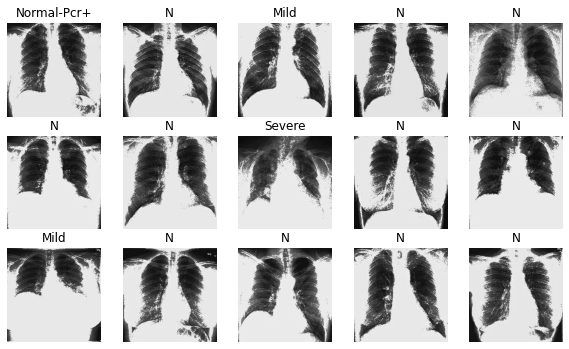

In [ ]:
train_ds = prepare_for_training(train_dataset)

train_image_batch, train_label_batch = next(iter(train_ds))

show_batch(train_image_batch.numpy(), train_label_batch.numpy())

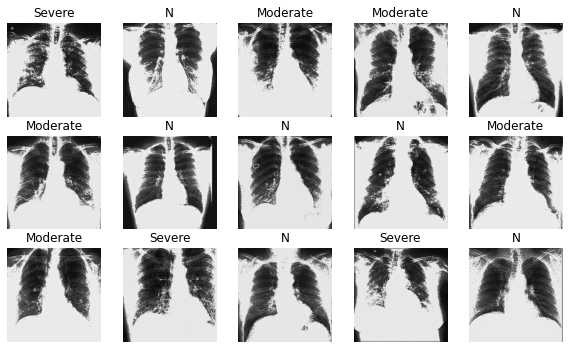

In [ ]:
val_ds = prepare_for_training(val_dataset)

val_image_batch, val_label_batch = next(iter(val_ds))

show_batch(val_image_batch.numpy(), val_label_batch.numpy())

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, MaxPool2D, Dropout, Flatten, Activation, MaxPooling2D, AveragePooling2D, Rescaling
from tensorflow.keras.layers import BatchNormalization

In [ ]:
model = Sequential()

model.add(Conv2D(filters=16, kernel_size=(3,3), strides=(1,1), padding='same', input_shape=(IMG_SIZE, IMG_SIZE, 3), data_format='channels_last'))
model.add(Activation("relu"))
model.add(Dropout(0.2))

model.add(Conv2D(filters=128, kernel_size=(3,3), strides=(1,1), padding='valid'))
model.add(Activation("relu"))

model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding='valid'))
model.add(Activation("relu"))

model.add(AveragePooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Activation("relu"))
model.add(Dropout(0.2))


model.add(Flatten())

model.add(Dense(128))
model.add(Activation("relu"))
model.add(Dropout(0.2))

model.add(Dense(84))
model.add(Activation("relu"))
model.add(Dropout(0.2))

model.add(Dense(64))
model.add(Activation("relu"))
model.add(Dropout(0.25))

model.add(Dense(len(CLASS_NAMES), activation='softmax'))

model.compile(optimizer="adam", loss='categorical_crossentropy', metrics=['accuracy'])


In [ ]:
model.summary()

In [ ]:
history = model.fit(
    train_ds,
    steps_per_epoch=STEPS_PER_EPOCH,
    epochs=50,
    validation_data=val_ds,
    validation_steps=VALIDATION_STEPS
)

Epoch 1/50
19/19 [==============================] - 23s 638ms/step - loss: 2.4512 - accuracy: 0.4194 - val_loss: 1.5466 - val_accuracy: 0.4844
Epoch 2/50
19/19 [==============================] - 12s 617ms/step - loss: 1.4280 - accuracy: 0.4622 - val_loss: 1.5225 - val_accuracy: 0.4635
Epoch 3/50
19/19 [==============================] - 12s 616ms/step - loss: 1.4099 - accuracy: 0.4688 - val_loss: 1.4046 - val_accuracy: 0.5052
Epoch 4/50
19/19 [==============================] - 12s 614ms/step - loss: 1.3977 - accuracy: 0.5049 - val_loss: 1.3613 - val_accuracy: 0.5312
Epoch 5/50
19/19 [==============================] - 12s 616ms/step - loss: 1.3573 - accuracy: 0.5016 - val_loss: 1.3481 - val_accuracy: 0.5000
Epoch 6/50
19/19 [==============================] - 12s 614ms/step - loss: 1.3324 - accuracy: 0.5148 - val_loss: 1.3360 - val_accuracy: 0.4688
Epoch 7/50
19/19 [==============================] - 12s 622ms/step - loss: 1.3508 - accuracy: 0.4836 - val_loss: 1.3589 - val_accuracy: 0.4896

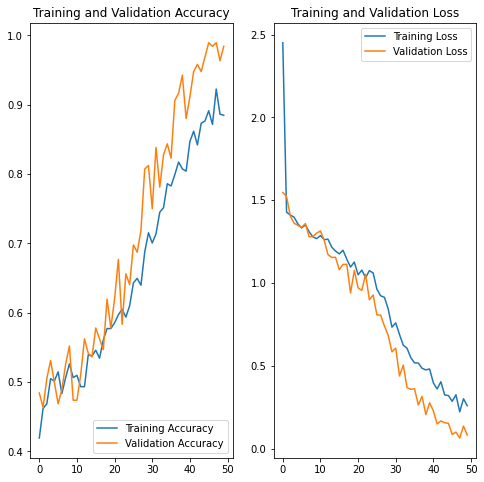

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(50)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc=4)
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc=1)
plt.title('Training and Validation Loss')
plt.show()

FINAL GRAPH

In [ ]:
def load_image(img_path, show = False):
    img_tensor, label = process_path(img_path) # Image With(height, width, channels)

    if show:
        img = cv2.cvtColor(img_tensor.numpy(), cv2.COLOR_RGB2GRAY)
        plt.imshow(img, cmap="gray")
        #plt.imshow(img_tensor.numpy())
        plt.title(CLASS_NAMES[label.numpy()==1][0].title())
        plt.axis('off')
        plt.show()

    img_tensor = np.expand_dims(img_tensor, axis=0) # (1, height, width, channels), add a dimension because the model expects this shape: (batch_size, height, width, channels)
    
    return img_tensor, label

In [ ]:
test_images = []
true_labels = []
for p in test_list_dataset.take(test_size):
  i, l = load_image(p, False)
  test_images.append(i)
  true_labels.append(l)

In [ ]:
test_dataset = tf.data.Dataset.from_tensor_slices(test_images)

In [ ]:
predictions = model.predict_generator(test_dataset)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  """Entry point for launching an IPython kernel.


In [ ]:
predict_labels = []
for pred in predictions:
    max_value = max(pred)
    boolArr = (pred == max_value)
    predict_labels.append(boolArr)

In [ ]:
true_labels = np.argmax(true_labels, axis=1)
predict_labels = np.argmax(predict_labels, axis=1)

In [ ]:
from sklearn.metrics import classification_report
confusion = tf.math.confusion_matrix(labels=true_labels, predictions=predict_labels, num_classes=len(CLASS_NAMES))
print(classification_report(true_labels, predict_labels, target_names=CLASS_NAMES))
print(confusion)

              precision    recall  f1-score   support

           N       1.00      0.98      0.99        48
    MODERATE       1.00      1.00      1.00        19
        MILD       0.88      1.00      0.93         7
 NORMAL-PCR+       1.00      1.00      1.00         5
      SEVERE       0.86      0.86      0.86         7

    accuracy                           0.98        86
   macro avg       0.95      0.97      0.96        86
weighted avg       0.98      0.98      0.98        86

tf.Tensor(
[[47  0  0  0  1]
 [ 0 19  0  0  0]
 [ 0  0  7  0  0]
 [ 0  0  0  5  0]
 [ 0  0  1  0  6]], shape=(5, 5), dtype=int32)


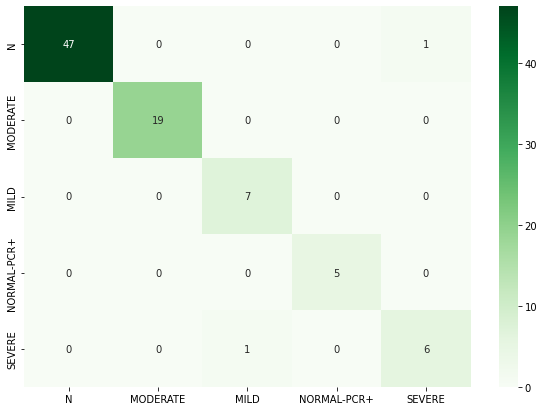

In [ ]:
import pandas as pd
import seaborn as sn
df_cm = pd.DataFrame(confusion, index = [i for i in CLASS_NAMES],
                    columns = [i for i in CLASS_NAMES], dtype=float)

plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True, cmap="Greens")
plt.show()

Image path:  b'/content/gdrive/My Drive/PREPROCESS/N/96a6fd2052db2283879a9cf3de7e35e0_crop.jpg'


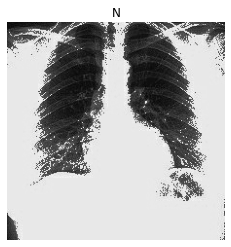

In [ ]:
#single image prediction
image_path = next(iter(test_list_dataset))
print('Image path: ', image_path.numpy())
img, lbl = load_image(image_path, True)
#pred = model.predict(img)
#pred = pred[0]


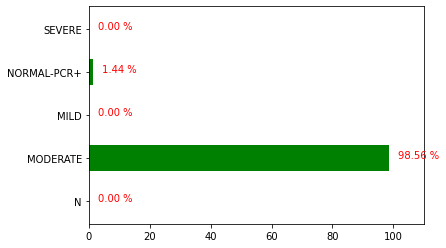

In [ ]:
x = CLASS_NAMES
x_pos = [i for i, _ in enumerate(x)]
y_pos = [(per * 100) for per in [0,0.9856,0,0.0144,0]]
plt.barh(x_pos, y_pos, height=0.6, color='green')

for i, v in enumerate(y_pos):
  val = str("{0:.2f}".format(v)) + ' %'
  plt.text(v + 3, i , val, color='red')

plt.yticks(x_pos, x)
plt.xlim([0,110])
plt.show()

GRAD CAM

###SAVE MODEL

In [ ]:
if not os.path.exists('models'):
  os.mkdir('models')

if not os.path.exists('models/trained'):
  os.mkdir('models/trained')

In [ ]:
# Saving as .h5 model

model.save('models/trained/model.h5')

In [ ]:
# Saving as .tflite model

''' Covnvert from saved model
converter = tf.lite.TFLiteConverter.from_saved_model('models/trained/model.h5')
'''

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quantized_model = converter.convert()
open("models/trained/model_lite.tflite", "wb").write(tflite_quantized_model)

INFO:tensorflow:Assets written to: /tmp/tmpir8jhgvr/assets


24818576